# Create plots for panels used in figure 3

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

In [2]:
# folder to save all panels for figure
savefolder = r"plots\fig3"

# file containing the data for the controls
results_ctrl_file = r"data\shape_analysis\histograms_HealthyControl_deformed_undeformed.txt"

In [3]:
#define a color seed for each patient
color_dict = {'VS': 'C0', 'VL': 'C1', 'RS': 'C2',
              'KM': 'C3', 'LM': 'C4'}

In [4]:
def logistic_growth(x, A, x_0, k):
    """The logistic growth fct"""
    return A/(1+np.exp(-k*(x-x_0)))

def deformed_probability_curve(df, v_min=0, v_max=3, binsize=.25):
    """Compute the values for the shape probability diagram to find a cell
    in a deformed state for velocities between v_min and v_max in the DataFrame df

    returns: *tuple* (deformed_bins, deformed_hist_normal)
        - deformed_bins: *array* limits for the bin ranges of the histogram
        - normalized counts for each velocity range
    """

    bins = int(v_max/binsize)   #number of Bins in histogram
    #find index of cells in a deformed state. Class definitions are:
    #1-parachute, 2-slipper, 3-asym. parachute, 5-multilobe, 7-undefined deformed
    #4-discocyte/undeformed, 6-tumbler
    deformed_index = ((df['shape'] == 1)
                      | (df['shape'] == 2)
                      | (df['shape'] == 3)
                      | (df['shape'] == 5)
                      | (df['shape'] == 7))

    #create new column in df that is True for deformed state
    df['deformed'] = False
    df['deformed'][deformed_index] = True

    df_deformed = df[deformed_index]

    deformed_hist, deformed_bins = np.histogram(np.array(df_deformed['velocity']),
                                                range = (v_min,v_max),
                                                bins = bins)
    #get the counts for all events to use for normalization
    all_hist, all_bins = np.histogram(np.array(df['velocity']),
                                      range = (v_min,v_max),
                                      bins = bins)

    #normalize the deformed histogram
    deformed_hist_normal = deformed_hist/all_hist

    return deformed_bins, deformed_hist_normal

In [5]:
#define dict to store fit values
dict_fitvalues = {}

def dict_fit_values_patient(patient, dict_fitvalues):
    result_summary_folder = r"data\shape_analysis\result_summaries"

    v_min = 0.
    v_max = 3.
    binsize = 0.25

    #bounds of the parameters in the logistic growth function for our example
    #f(x, A, x_0, k) = A/(1+np.exp(-k*(x-x_0)))
    # 0<A<1, 0<x_0<inf, 0<x_k<inf
    fit_bounds=(0, [1, np.inf, np.inf])

    result_file = os.path.join(result_summary_folder, patient + "_results_MCFM.tsv")
    df_results = pd.read_csv(result_file, sep='\t')

    dates = np.unique(df_results['date'])
    dates = np.sort(dates)
    day0 = pd.to_datetime(dates[0])

    #create dataframes to save fit parameters
    df_fit_all = pd.DataFrame()
    df_fit_healthy = pd.DataFrame()
    df_fit_unhealthy = pd.DataFrame()

    for num, date in enumerate(dates):
        df_date = df_results[df_results['date']==date]
        #create new Dataframe to work with, leave out skipped cells
        df = df_date[df_date['shape'] != 0]

        healthy_index = df['health'] == 0
        df_healthy = df[healthy_index]
        unhealthy_index = df['health'] == 1
        df_unhealthy = df[unhealthy_index]

        #calculate percentage of healthy cells in sample
        percentage_healthy = len(df_healthy)/len(df)

        bins, deformed_curve = deformed_probability_curve(df, v_min=v_min, v_max=v_max, binsize=binsize)
        bins_healthy, deformed_curve_healthy =  deformed_probability_curve(df_healthy,
                                                                           v_min=v_min, v_max=v_max, binsize=binsize)
        bins_unhealthy, deformed_curve_unhealthy =  deformed_probability_curve(df_unhealthy,
                                                                           v_min=v_min, v_max=v_max, binsize=binsize)

        bins_plot = bins[:-1]+binsize/2

        #exclude nan values before fitting
        ind_nonnan_all = ~np.isnan(deformed_curve)
        ind_nonnan_healthy = ~np.isnan(deformed_curve_healthy)
        ind_nonnan_unhealthy = ~np.isnan(deformed_curve_unhealthy)

        popt_all, pcov_all = curve_fit(logistic_growth,
                                       bins_plot[ind_nonnan_all], deformed_curve[ind_nonnan_all],
                                       bounds = fit_bounds)
        popt_healthy, pcov_healthy = curve_fit(logistic_growth, bins_plot[ind_nonnan_healthy],
                                               deformed_curve_healthy[ind_nonnan_healthy],
                                               bounds = fit_bounds)
        popt_unhealthy, pcov_unhealthy = curve_fit(logistic_growth, bins_plot[ind_nonnan_unhealthy],
                                                   deformed_curve_unhealthy[ind_nonnan_unhealthy],
                                                   bounds = fit_bounds)

        #days since treatment start
        treatment_days = (pd.to_datetime(date) - day0).days

        df_fit_all = df_fit_all.append({'A': popt_all[0], 'x0': popt_all[1],
                                        'k': popt_all[2], 'days': treatment_days,
                                        'percent healthy': percentage_healthy},
                                       ignore_index=True)
        df_fit_healthy = df_fit_healthy.append({'A': popt_healthy[0],
                                           'x0': popt_healthy[1],
                                           'k': popt_healthy[2],
                                            'days': treatment_days}, ignore_index=True)
        df_fit_unhealthy = df_fit_unhealthy.append({'A': popt_unhealthy[0],
                                             'x0': popt_unhealthy[1],
                                             'k': popt_unhealthy[2],
                                              'days': treatment_days}, ignore_index=True)

    dict_fitvalues[patient] = {'all': df_fit_all, 'healthy': df_fit_healthy, 'unhealthy': df_fit_unhealthy}

    return dict_fitvalues

Fill dictionary with patient data

In [6]:
patients = ['LM', 'KM']
labels = ["P4", "P5"]

for patient in patients:
    dict_fitvalues = dict_fit_values_patient(patient, dict_fitvalues)

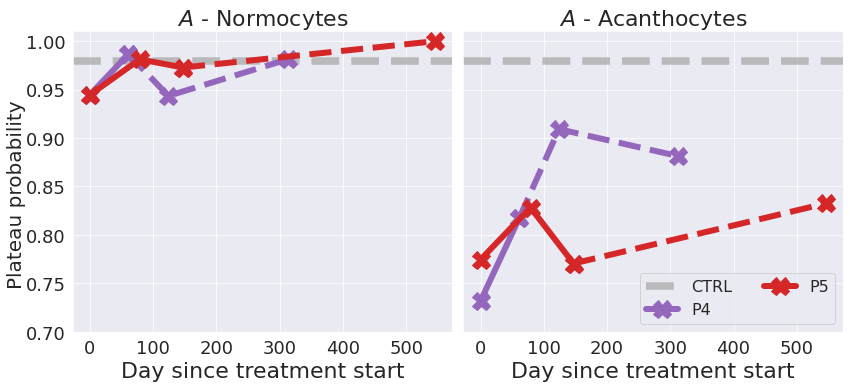

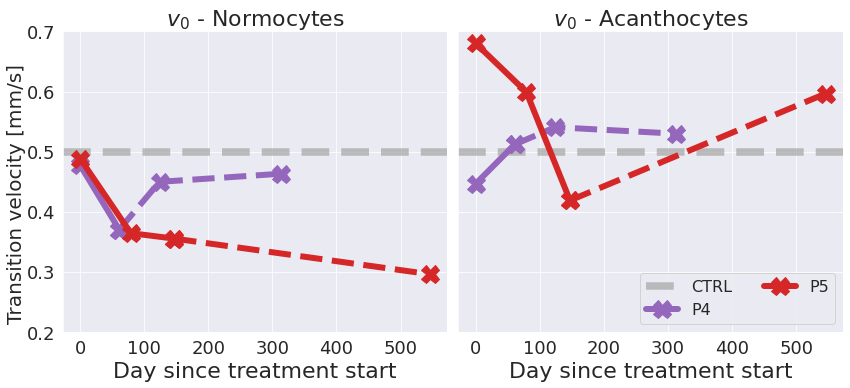

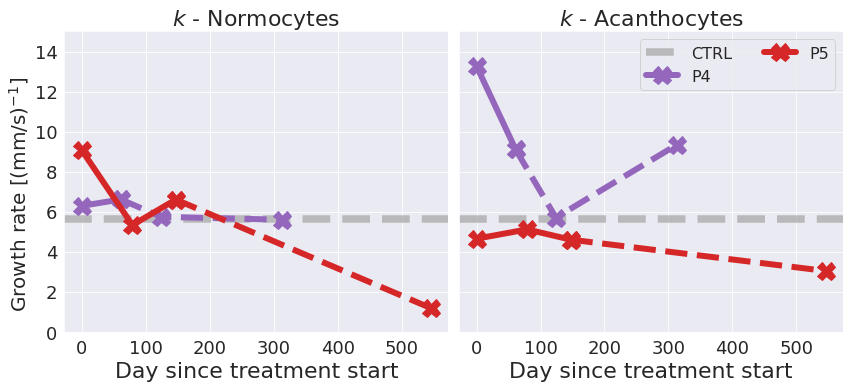

In [7]:
#compute control fit values
results_ctrl = np.loadtxt(results_ctrl_file)

v_min = 0.
v_max = 3.
binsize = 0.25
bins = int(v_max / binsize)

fontsize = 20
linewidth = 6
markersize = 18

v_ctrl = results_ctrl[:,0]
probs_ctrl = results_ctrl[:,3]
probs_ctrl_err = results_ctrl[:,4]

fit_bounds=(0, [1, np.inf, np.inf])

ind_vmax = v_ctrl <= v_max
v_ctrl = v_ctrl[ind_vmax]
probs_ctrl = probs_ctrl[ind_vmax]
probs_ctrl_err = probs_ctrl_err[ind_vmax]

popt_ctrl, pcov_ctrl = curve_fit(logistic_growth, v_ctrl, probs_ctrl,
                                 sigma = probs_ctrl_err, absolute_sigma=False,
                                 bounds = fit_bounds)

with sns.axes_style('darkgrid'):

    #plot control values in every plot
    for ii in range(3):
        plt.figure(ii,(12,5.5))

    fig = plt.figure(1)
    height_ratio = 4
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, height_ratios=[1,height_ratio])

    xlabel = 'Day since treatment start'

    params = ['A', 'x0', 'k']
    plot_titles = ['Normocytes', 'Acanthocytes']
    ylims = [(.7,1.01), (.2,.7),(0,15)]

    for jj, patient in enumerate(patients):
        data = dict_fitvalues[patient]
        color = color_dict[patient]

        for ii in range(len(params)):
            para = params[ii]
            fig = plt.figure(ii)

            for n, health in enumerate(['healthy', 'unhealthy']):
                df_plot = data[health]

                ax=plt.subplot(1,2,n+1)
                #plot control line first
                if jj==0:
                    if health=='unhealthy':
                        plt.axhline(popt_ctrl[ii], color='darkgray', ls='--', lw=1.25*linewidth, alpha=.75,
                                    label='CTRL')
                    else:
                        plt.axhline(popt_ctrl[ii], color='darkgray', ls='--', lw=1.25*linewidth, alpha=.75)

                if patient=='LM':
                    plt.plot(df_plot['days'][:-2], df_plot[para][:-2], c=color, label=labels[jj],
                             marker='X', lw=linewidth, markersize=markersize)
                    plt.plot(df_plot['days'][-3:], df_plot[para][-3:], '--', c=color,
                             marker='X', lw=linewidth, markersize=markersize)
                else:
                    plt.plot(df_plot['days'][:-1], df_plot[para][:-1], c=color, label=labels[jj],
                             marker='X', lw=linewidth, markersize=markersize)
                    plt.plot(df_plot['days'][-2:], df_plot[para][-2:], '--', c=color,
                             marker='X', lw=linewidth, markersize=markersize)

                plt.ylim(ylims[ii])
                plt.xlabel(xlabel, fontsize=fontsize+2)
                plt.xticks([0,100,200,300,400,500])
                plt.tick_params(axis='both', which='both', labelsize=fontsize-2)

                if para=='x0':
                    plot_para = 'v_0'
                else:
                    plot_para = para
                plt.title(r'${}$ - {}'.format(plot_para, plot_titles[n]), fontsize=fontsize+2)

                if health=='unhealthy':
                    ax.get_yaxis().set_ticklabels([])

    fig = plt.figure(0)
    fig.supylabel("Plateau probability", fontsize=fontsize)
    plt.legend(ncol=2, fontsize=fontsize-4, title_fontsize=fontsize)
    plt.tight_layout()
    savename = "fig3A_plateau_probability_lithium"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')

    fig=plt.figure(1)
    fig.supylabel("Transition velocity [mm/s]", fontsize=fontsize)
    plt.legend(loc='lower right', ncol=2, fontsize=fontsize-4, title_fontsize=fontsize)
    plt.tight_layout()
    savename = "fig3B_trasition_velocity_lithium"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')

    fig = plt.figure(2)
    fig.supylabel(r"Growth rate [(mm/s)$^{-1}$]", fontsize=fontsize)
    plt.legend(ncol=2, fontsize=fontsize-4, title_fontsize=fontsize)
    plt.tight_layout()
    savename = "fig3C_growth_rate_lithium"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')